In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from io import BytesIO
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import Image

# Load the dataset from a JSON file
df = pd.read_json("loan_approval_dataset.json")


In [17]:
print(df.head)

<bound method NDFrame.head of           Income       Age  Experience  Married/Single  House_Ownership  \
0      -1.283145 -1.579604   -1.180232               1                2   
1       0.895457 -0.583344   -0.014067               1                2   
2      -0.349269  0.940348   -1.013637               0                2   
3       0.437526 -0.524740   -1.346827               1                2   
4       0.268128 -0.173119    0.152528               1                2   
...          ...       ...         ...             ...              ...   
251995  1.097092 -0.407533    0.485719               1                2   
251996 -0.748199 -1.403793   -0.014067               1                2   
251997 -0.164913 -0.231723   -0.513852               1                2   
251998  0.524618 -0.290326   -1.680018               1                2   
251999  1.415108  1.174762    1.152099               1                2   

        Car_Ownership  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag 

In [2]:
# Data Exploration
data_info = df.info()
data_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 26.9+ MB


C:\Users\NATI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


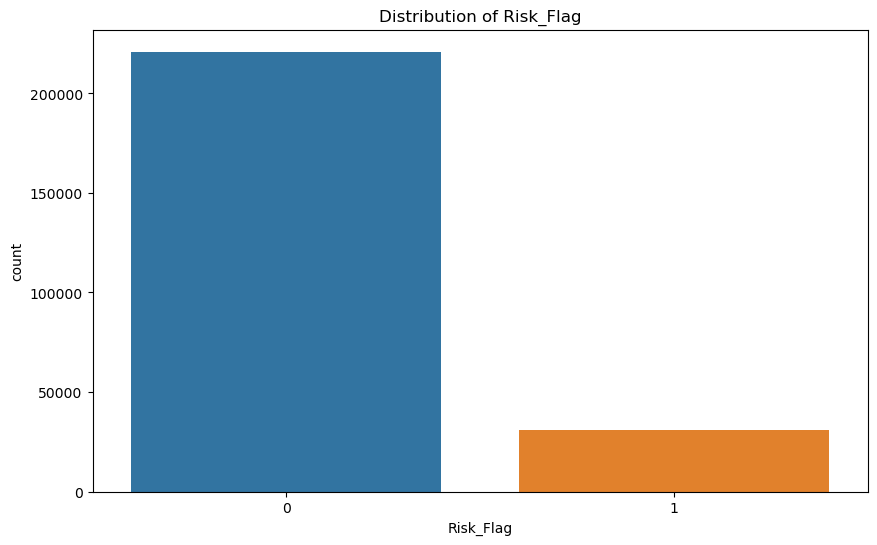

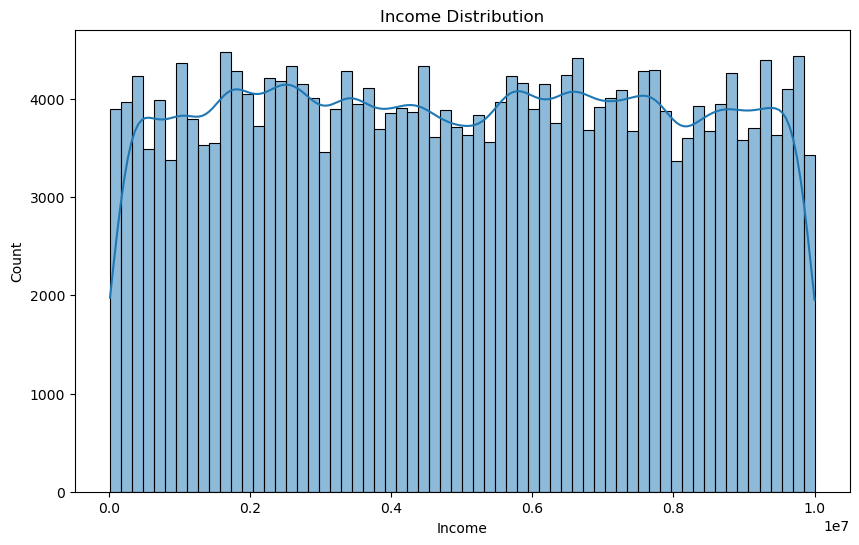

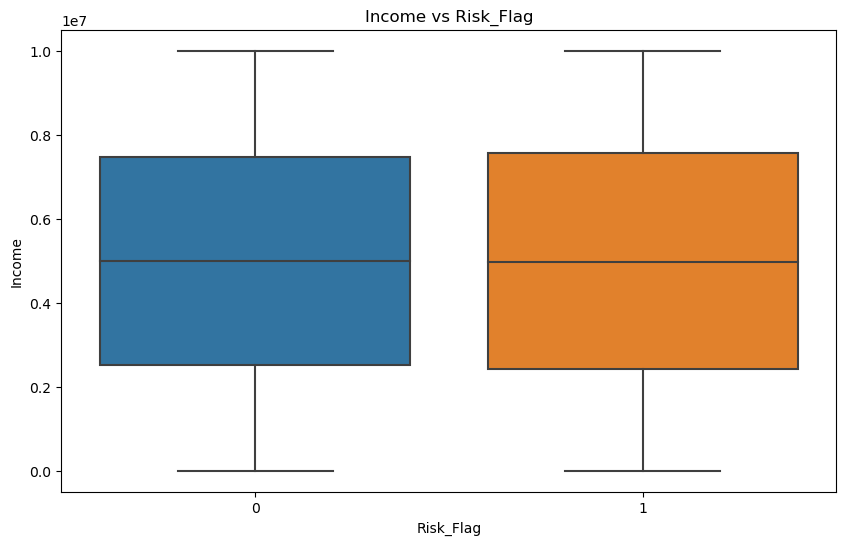

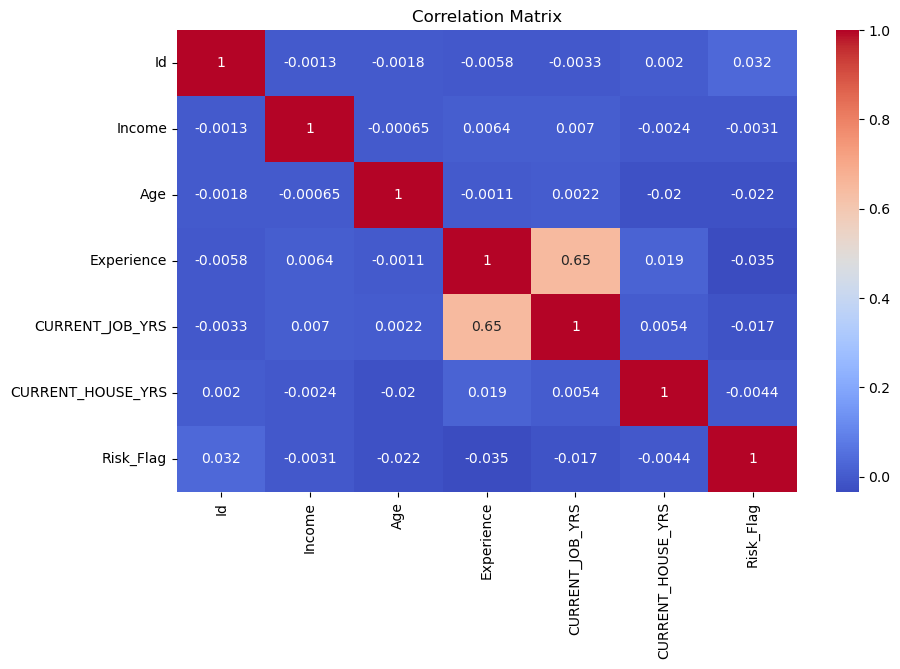

In [3]:
# Data Visualizations
figures = []

# Risk_Flag Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk_Flag', data=df)
plt.title('Distribution of Risk_Flag')
buffer = BytesIO()
plt.savefig(buffer, format='png')
figures.append(buffer)

# Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True)
plt.title('Income Distribution')
buffer = BytesIO()
plt.savefig(buffer, format='png')
figures.append(buffer)

# Income vs Risk_Flag
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk_Flag', y='Income', data=df)
plt.title('Income vs Risk_Flag')
buffer = BytesIO()
plt.savefig(buffer, format='png')
figures.append(buffer)

# Correlation Matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
buffer = BytesIO()
plt.savefig(buffer, format='png')
figures.append(buffer)

In [4]:
# Data Preprocessing

from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encode categorical variables
label_encoder = LabelEncoder()
df['Married/Single'] = label_encoder.fit_transform(df['Married/Single'])
df['House_Ownership'] = label_encoder.fit_transform(df['House_Ownership'])
df['Car_Ownership'] = label_encoder.fit_transform(df['Car_Ownership'])

In [5]:
# One-Hot Encoding for Profession, CITY, and STATE
df = pd.get_dummies(df, columns=['Profession', 'CITY', 'STATE'])

# Drop the 'Id' column as it is not useful for prediction
df.drop(columns=['Id'], inplace=True)

In [6]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Split the data into features and target variable
X = df.drop(columns=['Risk_Flag'])
y = df['Risk_Flag']

In [7]:
# Model Building and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
}

model_performance = {}
confusion_matrices = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"Model: {model_name}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    
    model_performance[model_name] = {
        'roc_auc_score': roc_auc,
        'classification_report': class_report
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append((model_name, cm))
    

Model: RandomForest
ROC-AUC Score: 0.94
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     44201
           1       0.59      0.54      0.56      6199

    accuracy                           0.90     50400
   macro avg       0.76      0.74      0.75     50400
weighted avg       0.89      0.90      0.89     50400

Model: GradientBoosting
ROC-AUC Score: 0.64
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.67      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg       0.77      0.50      0.47     50400
weighted avg       0.85      0.88      0.82     50400

Model: LogisticRegression
ROC-AUC Score: 0.62
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       1.00      0.00      0.00      6199

    accuracy                           0.88     5040

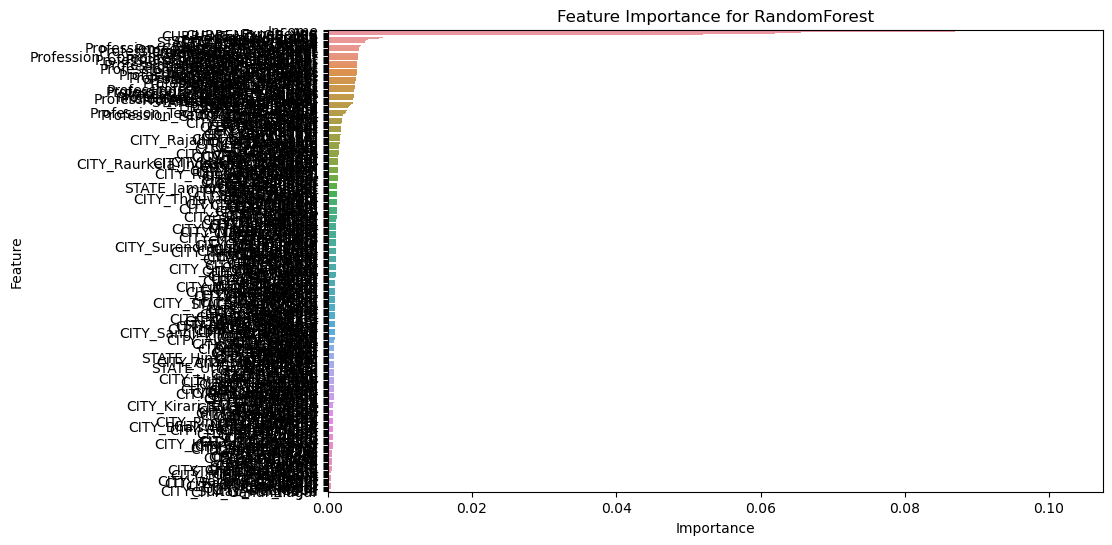

In [9]:

# Feature Importance for RandomForest (example)
importances = models['RandomForest'].feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for RandomForest')
buffer = BytesIO()
plt.savefig(buffer, format='png')
figures.append(buffer)


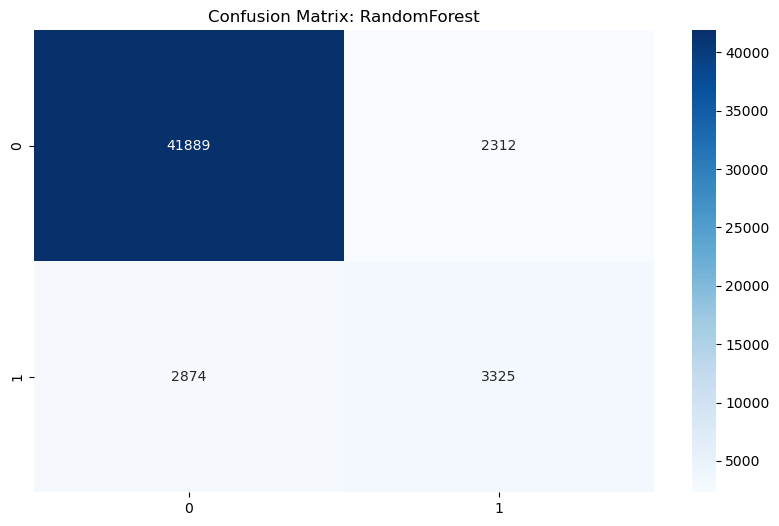

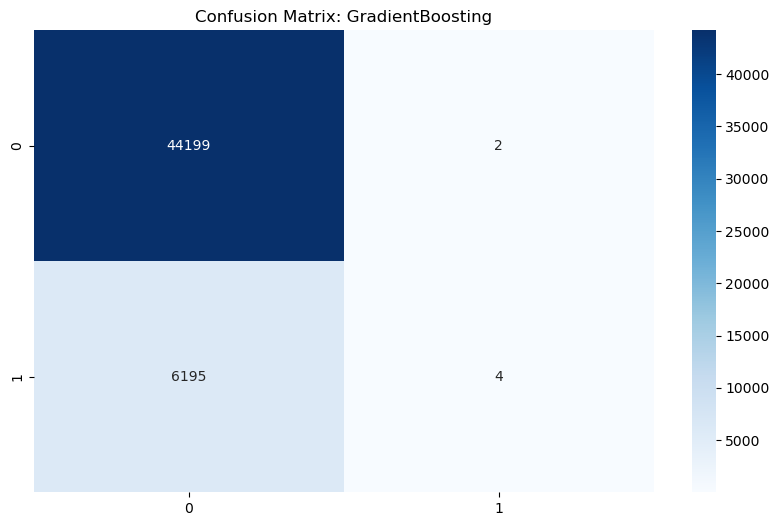

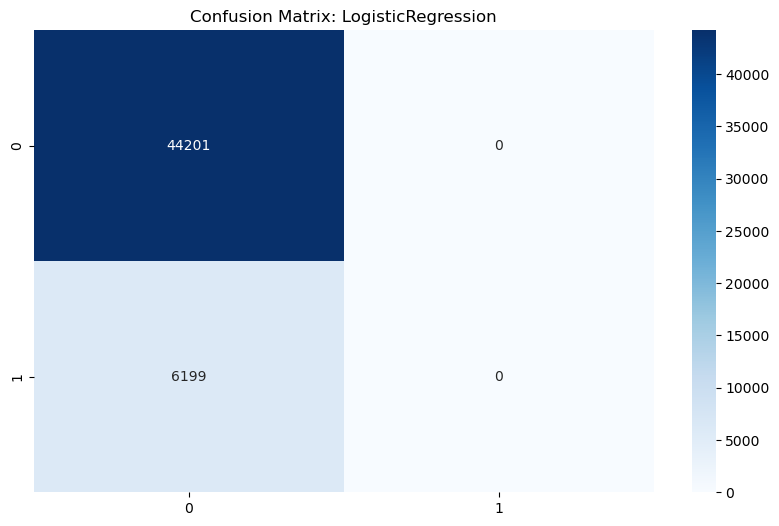

In [16]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
import json  # Import the json module
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate the PDF report
def generate_pdf_report(figures, model_performance, confusion_matrices, data_info, data_description):
    pdf_buffer = BytesIO()
    doc = SimpleDocTemplate(pdf_buffer, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []
    
    # Add title
    story.append(Paragraph("Loan Approval Data Analysis Report", styles['Title']))
    story.append(Spacer(1, 12))
    
    # Data Visualizations
    story.append(Paragraph("Data Visualizations", styles['Heading2']))
    story.append(Spacer(1, 12))
    for fig in figures:
        img = Image(fig)
        img.drawHeight = 6 * inch
        img.drawWidth = 6 * inch
        story.append(img)
        story.append(Spacer(1, 12))
        
    # Data Exploration Insights
    story.append(Paragraph("Data Exploration Insights", styles['Heading2']))
    story.append(Spacer(1, 12))
    story.append(Paragraph(str(data_info), styles['Normal']))
    story.append(Spacer(1, 12))
    story.append(Paragraph(str(data_description), styles['Normal']))
    story.append(Spacer(1, 12))
    
    # Model Performance
    story.append(Paragraph("Model Performance", styles['Heading2']))
    story.append(Spacer(1, 12))
    for model_name, performance in model_performance.items():
        story.append(Paragraph(f"Model: {model_name}", styles['Heading3']))
        story.append(Spacer(1, 12))
        story.append(Paragraph(f"ROC-AUC Score: {performance['roc_auc_score']:.2f}", styles['Normal']))
        story.append(Spacer(1, 12))
        story.append(Paragraph("Classification Report:", styles['Normal']))
        
        # Convert the classification report dictionary to a string
        classification_report_str = json.dumps(performance['classification_report'], indent=4)
        story.append(Paragraph(classification_report_str, styles['Normal']))
        story.append(Spacer(1, 12))
    
    # Confusion Matrices
    story.append(Paragraph("Confusion Matrices", styles['Heading2']))
    story.append(Spacer(1, 12))
    for model_name, cm in confusion_matrices:
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {model_name}')
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img = Image(buffer)
        img.drawHeight = 6 * inch
        img.drawWidth = 6 * inch
        story.append(img)
        story.append(Spacer(1, 12))
    
    doc.build(story)
    pdf_buffer.seek(0)
    return pdf_buffer

# Generate the PDF report
pdf_report = generate_pdf_report(figures, model_performance, confusion_matrices, data_info, data_description)

# Save the PDF report to a file
with open("Loan_Approval_Report.pdf", "wb") as f:
    f.write(pdf_report.read())
